<a href="https://colab.research.google.com/github/olesyamba/Risk_analysis/blob/main/portfolio_risk_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
!pip install --upgrade pandas>=1.2
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
!pip install yfinance
import yfinance as yf

# 1. Аппроксимация риска: коэффициенты чувствительности

Цена актива как функция от значения риск-фактора.

Примеры:

- Акции:
  
 $S_t = S_{t-1}\cdot e^{r_t}$, где $S_{t-1}$ - цена акции начала периода, $r_t$

- Бескупонная облигации:

  $B_t = N\cdot e^{-y_t(s)\cdot s}$, где  $y_t(s)$ - процентна ставка непрерывного начисления (%/годовых), $s$ -срок до погашения в годах.

- Опцион:

  $C_t = f(S_t, \sigma_t)$ -  где $S_{t-1}$ - цена базового актива, $\sigma_t$ - волатильность его цены.

## Пример

Зависимость цены актива $P$ от двух риск-факторов $X,\,Y$  моделируется функцией
$$
P(x,\,y) = \frac{x - F}{(1+y)^2},
$$
$F=55$. Факторы $X, Y$ нестационарны и положительны, так что имеет смысл переходить к доходностям. Текущие значения риск-факторов: $X=50,\,y=0.05$. Найдите текущие чувствительности доходности актива к доходностям этих двух факторов.


1. Переходим к доходностям (или разностям). Факторы риска -- доходности $\frac{X-X_0}{X_0}$ и $\frac{Y-Y_0}{Y_0}$. Вместо цены -- тоже доходность: $\frac{P-P_0}{P_0}$.

2. Считаем чувствительность:
$$
\frac{\partial\left(\frac{P(x,y)-P(x_0,y_0)}{P(x_0,y_0)}\right)}{\partial\left(\frac{x-x_0}{x_0}\right)}=\frac{\partial P(x,y)}{\partial x}\cdot\frac{x_0}{P(x_0,y_0)}
$$

In [ ]:
F = 55
x0 = 50
y0 = 0.05


def price_asset(x, y):
  return (x - F) / (1 + y)**2

def return_asset(rx, ry):
  return price_asset(x0 * (1 + rx), y0 * (1 + ry)) / price_asset(x0, y0) - 1

def log_return_asset(lrx, diffy):
  return np.log( price_asset(x0 * np.exp(lrx), y0 + diffy)  /  price_asset(x0, y0) )

In [ ]:
e = 1e-8
print((return_asset(e, 0) - return_asset(0, 0)) / e, (return_asset(0, e) - return_asset(0, 0)) / e)

-9.999999983634211 -0.09523810629019636


In [ ]:
from autograd import grad
grad(return_asset, [0, 1]) (0.0, 0.0)

(array(-10.), array(-0.0952381))

# 2. Декомпозиция на риск-факторы

Портфель состоит из одной акции JP Morgan Chase, двух акций Microsoft, две Exxon Mobil и трёх акций Pfizer. Рассматривается два риск-фактора -- индекс S&P 500, курс юаня к доллару и цена на нефть. Временной период -- с 1 января по 31 декабря 2020 года.

In [ ]:
tickers = {
    "JPMorgan": "JPM",
    "Microsoft": "MSFT",
    "Pfizer": "PFE",
    "ExxonMobil": "XOM",
    "SnP": "^GSPC",
    "FX": "CNYUSD=X",
    "Oil": "CL=F"
}

portfolio = {
    "JPMorgan": 1,
    "Microsoft": 1,
    "ExxonMobil":2,
    "Pfizer": 3
}

factors = ["SnP", "FX", "Oil"]

portfolio_composition = pd.Series(portfolio)
portfolio_composition

JPMorgan      1
Microsoft     1
ExxonMobil    2
Pfizer        3
dtype: int64

In [ ]:
# Вспомогательная функция для исправления дат при загрузке валют и ценных бумаг

def norm_datetimeidx(table):
  table.index = table.index.tz_convert(None).normalize()
  return table

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,JPMorgan,Microsoft,Pfizer,ExxonMobil,SnP,FX,Oil
Date,,,,,,,
2020-01-02,128.747040,156.591995,33.538971,59.971916,3257.850098,0.143633,61.180000
2020-01-03,127.048035,154.642151,33.359020,59.489777,3234.850098,0.143608,63.049999
2020-01-06,126.947037,155.041885,33.316177,59.946548,3246.280029,0.143585,63.270000
2020-01-07,124.788826,153.628265,33.204781,59.455936,3237.179932,0.143379,62.700001
2020-01-08,125.762321,156.075287,33.470413,58.559322,3253.050049,0.144001,59.610001


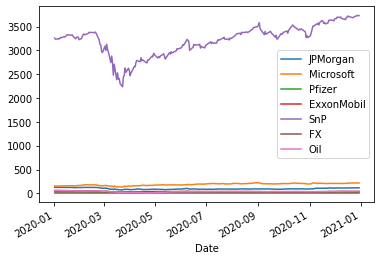

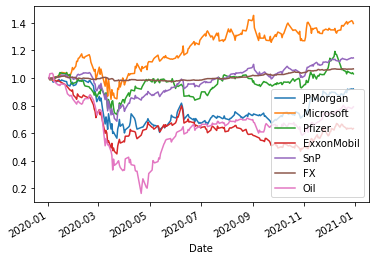

In [ ]:
# Загрузим данные в единую таблицу

quote_data = pd.DataFrame(
    {
        factor: norm_datetimeidx(yf.download(ticker, "2020-01-01", "2020-12-31")['Adj Close'])
        for factor, ticker in tickers.items()
    }
)

quote_data.dropna(inplace=True) # для простоты удалим строки с пропусками данных
quote_data = quote_data[quote_data.Oil > 0]
quote_data.plot()
(quote_data/quote_data.iloc[0,:]).plot()
quote_data.head(5)

,JPMorgan,Microsoft,Pfizer,ExxonMobil,SnP,FX,Oil
Date,,,,,,,
2020-01-03,-0.013196,-0.012452,-0.005365,-0.008039,-0.007060,-0.000172,0.030566
2020-01-06,-0.000795,0.002585,-0.001284,0.007678,0.003533,-0.000158,0.003489
2020-01-07,-0.017001,-0.009118,-0.003344,-0.008184,-0.002803,-0.001434,-0.009009
2020-01-08,0.007801,0.015928,0.008000,-0.015080,0.004902,0.004334,-0.049282
2020-01-09,0.003651,0.012493,-0.004352,0.007656,0.006655,-0.000115,-0.000839


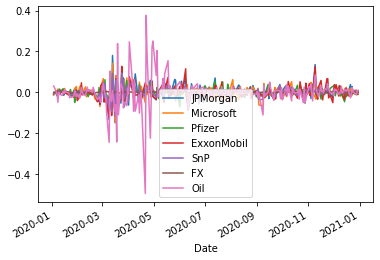

In [ ]:
returns = quote_data.pct_change().dropna()
returns.plot()
returns.head(5)

In [ ]:
# Рассмотрим факторную модель

from statsmodels.formula.api import ols

print('Корреляционная матрица факторов:\n',returns[factors].corr())

ols("JPMorgan ~ SnP + FX + Oil", returns).fit().summary()

Корреляционная матрица факторов:
           SnP        FX       Oil
SnP  1.000000 -0.013997  0.304237
FX  -0.013997  1.000000  0.013092
Oil  0.304237  0.013092  1.000000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               JPMorgan   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     135.4
Date:                Thu, 20 Oct 2022   Prob (F-statistic):           1.51e-49
Time:                        09:03:57   Log-Likelihood:                 541.65
No. Observations:                 222   AIC:                            -1075.
Df Residuals:                     218   BIC:                            -1062.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0004      0.001     -0.302      0.763      -0.003       0.002
SnP            1.2579      0.066     19.197      0.000       1.129       1.387
FX            -1.3011      0.498     -2.615      0.010      -2.282      -0.320
Oil           -0.0146      0.021     -0.693      0.489      -0.056       0.027
==============================================================================
Omnibus:                       64.487   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              300.952
Skew:                           1.050   Prob(JB):                     4.46e-66
Kurtosis:                       8.304   Cond. No.                         348.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
import statsmodels.api as sm

# data_returns = returns[portfolio]
# factor_returns = returns[factors]

factors_map = {
    "JPMorgan": ["SnP","FX"],
    "Microsoft": ["SnP"],
    "ExxonMobil": ["SnP", "Oil"],
    "Pfizer": ["SnP"]
}

# Коэффициенты регрессии (коэффициенты чувствительности доходностей к риск-факторам)
factor_loadings = {
    name: sm.OLS(returns[name], returns[factors_map[name]]).fit().params # no constant
    for name in portfolio
}

indvidual_risk ={
    name: np.sqrt(sm.OLS(returns[name], returns[factors_map[name]]).fit().mse_resid) # std остатков от регрессии
    for name in portfolio
}

print('Словарь коэффициентов регрессии:\n', factor_loadings)
print('\nСловарь ст.отклонения остатков:\n', indvidual_risk)

Словарь коэффициентов регрессии:
 {'JPMorgan': SnP    1.243301
FX    -1.323133
dtype: float64, 'Microsoft': SnP    1.12719
dtype: float64, 'ExxonMobil': SnP    0.982189
Oil    0.070108
dtype: float64, 'Pfizer': SnP    0.699992
dtype: float64}

Словарь ст.отклонения остатков:
 {'JPMorgan': 0.021217060130120344, 'Microsoft': 0.014193412416881044, 'ExxonMobil': 0.024442701300611585, 'Pfizer': 0.018133273132935897}


In [ ]:
factor_loadings['ExxonMobil']

In [ ]:
sensitivities = pd.DataFrame(factor_loadings).T.fillna(0)
sensitivities

,FX,Oil,SnP
JPMorgan,-1.323133,0.000000,1.243301
Microsoft,0.000000,0.000000,1.127190
ExxonMobil,0.000000,0.070108,0.982189
Pfizer,0.000000,0.000000,0.699992


In [ ]:
errors = pd.Series(indvidual_risk).rename('Errors')
errors

JPMorgan      0.021217
Microsoft     0.014193
ExxonMobil    0.024443
Pfizer        0.018133
Name: Errors, dtype: float64

# 2. Портфельный риск


## VaR дельта-нормальным методом

Это означает, что факторы имеют совместное нормальное распределение, и вносят свой вклад в портфельный риск в соответствии с матрицей чувствительностей.

In [ ]:
# Начнем с факторов

covariance_matrix = factor_returns.cov() # ковариационная матрица
expected_returns = factor_returns.mean() # вектор средних
print(covariance_matrix, "\n\n", expected_returns)

              SnP            FX       Oil
SnP  5.264020e-04 -9.242840e-07  0.000498
FX  -9.242840e-07  8.284228e-06  0.000003
Oil  4.979890e-04  2.688238e-06  0.005090 

 SnP    0.000877
FX     0.000293
Oil    0.001704
dtype: float64


In [ ]:
# Состав портфеля (в штуках/лотах)

portfolio_composition

JPMorgan      1
Microsoft     1
ExxonMobil    2
Pfizer        3
dtype: int64

In [ ]:
# Стоимостная структура портфеля

portfolio_dollar_composition = portfolio_composition * quote_data.loc[quote_data.index.max(),portfolio] # Внимание к дате - это важно для правильного определения стоимостной структуры портфеля
portfolio_value = portfolio_dollar_composition.sum()

weights = portfolio_dollar_composition / portfolio_value
weights

JPMorgan      0.229490
Microsoft     0.422810
ExxonMobil    0.147118
Pfizer        0.200581
dtype: float64

In [ ]:
display(sensitivities)
display(weights)

,FX,Oil,SnP
JPMorgan,-1.323133,0.000000,1.243301
Microsoft,0.000000,0.000000,1.127190
ExxonMobil,0.000000,0.070108,0.982189
Pfizer,0.000000,0.000000,0.699992


JPMorgan      0.229490
Microsoft     0.422810
ExxonMobil    0.147118
Pfizer        0.200581
dtype: float64

In [ ]:
 weights @ sensitivities # коэффициенты чувствительности портфеля к риск-факторам

FX    -0.303646
Oil    0.010314
SnP    1.046816
dtype: float64

In [ ]:
# Параметры распределения доходности портфеля

portfolio_mu = (weights @ sensitivities) @ expected_returns

# portfolio_sigma = np.sqrt((weights @ sensitivities) @ covariance_matrix @ (sensitivities.T @ weights))
portfolio_sigma = np.sqrt((weights @ sensitivities) @ covariance_matrix @ (sensitivities.T @ weights) + weights**2 @ errors**2) # предполагаю индивидуальные риски независимыми

print('Ожидаемая доходность: {:.2%}, волатильности: {:.2%}'.format(portfolio_mu, portfolio_sigma))

Ожидаемая доходность: 0.08%, волатильности: 2.60%


In [ ]:
# Параметры VaR

level = 0.99

VaR = - ss.norm(portfolio_mu, portfolio_sigma).ppf(1-level)
print('Относительный VaR: {:.2%}, абсолютный VaR: {:.2f}'.format(VaR, VaR * portfolio_value))

Относительный VaR: 5.96%, абсолютный VaR: 30.79


In [ ]:
# VaR можно было бы вычислить и сразу в деньгах (но это не принципиально)

portfolio_mu = portfolio_dollar_composition @ sensitivities @ expected_returns
portfolio_sigma = np.sqrt(portfolio_dollar_composition @ sensitivities @ covariance_matrix @ sensitivities.T @ portfolio_dollar_composition)
portfolio_mu, portfolio_sigma

VaR = - ss.norm(portfolio_mu, portfolio_sigma).ppf(0.01)
VaR

28.739208596202605

## VaR историческим методом

In [ ]:
# Просто формируем историческую выборку
scenarios = factor_returns @ sensitivities.T

portfolio_scenarios = scenarios @ weights

VaR = - portfolio_scenarios.quantile(1 - level, interpolation='higher')
VaR_dollars = - (scenarios @ portfolio_dollar_composition).quantile(1 - level, interpolation='higher')

VaR, VaR * portfolio_value, VaR_dollars

In [ ]:
factor_returns

In [ ]:
portfolio_scenarios.hist(bins=30)
plt.axvline(-VaR, color='r')

# Задача хеджирования
Дано: чувствительность доходности портфеля: 0.5 к S&P и -0.3 к нефти.

2 хеджирующих инструмента:

- фьючерс на S&P: чувствительность к S&P -- 1.04,
- фьючерс на нефть: чувствительность к индексу -0.1 и к нефти 0.95.

Найти состав хеджирующего портфеля: $x$ фьючерсов на S&P и $y$ фьючерсов на нефть.

Хеджирование удалось: все чувствительности = 0.

Чувствительность к S&P: $$0.5 + x\cdot 1.04 + y\cdot(-0.1) = 0$$
Чувствительность к нефти: $$-0.3 + y\cdot 0.95=0$$

Решение: $x=-0.45,\,y=0.32$ -- это не штуки, а веса, т.к. исходные чувствительности -- относительные. Их нужно домножить на стоимость портфеля, чтобы получить доллары.

Если бы исходные чувствительности были в долларах, то ответ в штуках.

### А теперь то же самое, но в штуках
Дано: чувствительность цены портфеля в млн. долларов: 5 к S&P и -3 к нефти.

2 хеджирующих инструмента: фьючерс на S&P: чувствительность к S&P -- 104,000 долларов, фьючерс на нефть: чувствительность к индексу -10,000 долларов и к нефти 95,000 долларов.

Найти состав хеджирующего портфеля: $x$ фьючерсов на S&P и $y$ фьючерсов на нефть.

Хеджирование удалось: все чувствительности = 0.
Чувствительность к S&P: $$5,000,000 + x\cdot 104,000 + y\cdot(-10,000) = 0$$
Чувствительность к нефти: $$-3,000,000 + y\cdot 95,000=0$$


In [ ]:
hedging_amounts = np.linalg.solve(np.array([[104000, -10000],[0, 95000]]), np.array([5000000,-3000000]))
hedging_amounts = np.round(hedging_amounts)
hedging_amounts

## Задача
Портфель имеет чувствительности в 15 млн и 20 млн к риск-факторам A и B.
Дана матрица ковариаций доходностей факторов A и B:

| |A|B|
|:-|:-:|:-:|
|A|0.01|0.005|
|B|0.005|0.03|

VaR на уровне 99% оценивают дельта-нормальным методом. Лимит на VaR равен 5 млн. Захеджировать портфель инструментом с чувствительностями 1 млн и -2 млн соответственно -- так, чтобы уложиться в лимит.

In [ ]:
covariance = pd.DataFrame({'A': [0.01,0.005], 'B': [0.005, 0.03]}, index=['A','B'])
sensitivities = pd.Series({'A': 15, 'B': 20})
portfolio_sigma = np.sqrt(sensitivities @ covariance @ sensitivities.T)
VaR = ss.norm.ppf(0.99) * portfolio_sigma
VaR

9.66204838197819

Пусть $s$ -- вектор чувствительностей портфеля, $a$ -- чувствительности инструмента, $x$ -- количество инструмента в хеджирующем портфеле.
$$
\sigma^2=(s + a\cdot x)^T\Sigma(s+a\cdot x)\to\min
$$
$$
a^T\Sigma a\cdot x^2 + 2a^T\Sigma s \cdot x\to\min
$$
$$
x = -\frac{a^T\Sigma s}{a^T\Sigma a}
$$

In [ ]:
a = pd.Series({'A': 1, 'B': -2})
x = np.round( - (a@ covariance @ sensitivities) / (a @ covariance @ a))
x

In [ ]:
portfolio_sigma = np.sqrt((sensitivities + x * a) @ covariance @ (sensitivities + x * a))
VaR = ss.norm.ppf(0.99) * portfolio_sigma
VaR

Снизить VaR меньше, чем до 5.8 млн при помощи этого инструмента нельзя.